In [1]:
from pathlib import Path
root_path = Path.cwd().parent.absolute()
import sys
sys.path.append(str(root_path))

In [2]:
import torch as torch
from torch.distributions import MultivariateNormal
device = torch.device('cuda:3' if torch.cuda.is_available() else 'cpu')

import numpy as np 
import matplotlib.pyplot as plt

import parametric_pushforward.data_sets as toy_data
from parametric_pushforward.parametric_mlp import order_state_to_tensor
from parametric_pushforward.visualization import path_visualization_with_trajectories,path_visualization_particles,create_particle_animation
from parametric_pushforward.spline import Assemble_spline
from parametric_pushforward.obstacles import obstacle_cost_stunnel, obstacle_cost_vneck, obstacle_cost_gmm,congestion_cost,geodesic
from parametric_pushforward.opinion import PolarizeDyn
from parametric_pushforward.setup_density_path_problem import load_boundary_models,get_activation,opinion_dynamics_setup,get_potential_functions

from geomloss import SamplesLoss

sinkhorn = SamplesLoss(loss = 'sinkhorn', p = 2, blur = 0.05)

import os
import yaml


Successfully patched Parametric_Euler and Parametric_Midpoint
Successfully patched Parametric_Euler and Parametric_Midpoint
/work/Sebas/Density_Path_Opt/Parametric_pushforward


In [3]:
torch.manual_seed(0)
np.random.seed(0)
torch.cuda.manual_seed(0)

In [4]:
# name of experiment
exp_dir = str(root_path)+ '/experiments/gaussian0_s_to_gaussian1_s_pot_congestion_cost_obstacle_cost_stunnel_20250430_130948'
yaml_path = os.path.join(exp_dir, 'config.yaml')
with open(yaml_path) as file:
    config = yaml.load(file, Loader=yaml.FullLoader)

In [5]:

name_data0 = config['data']['source']['name']
checkpt0 = 'final'#'checkpoint_1999'
name_data1 = config['data']['target']['name']
checkpt1 = 'final'#'checkpoint_1999'

arch_dims = [config['architecture']['input_dim'],config['architecture']['hidden_dim'],config['architecture']['num_layers']]
activation = get_activation(config['architecture']['activation'])

arch = arch_dims+[activation]

spline_type = config['spline']['type']


prior = MultivariateNormal(torch.zeros(2).to(device),torch.eye(2).to(device))

state0,state1 = load_boundary_models(config,device)
theta0 = order_state_to_tensor(state0)
theta1 = order_state_to_tensor(state1)

if config.get('opinion_dynamics',{}).get('active',False):
    print('Opinion dynamics active')
    opinion_dynamics = opinion_dynamics_setup(config)
    ke_modifier = [PolarizeDyn(opinion_dynamics).to(device)]
else:
    ke_modifier = None


In [6]:
# Build spline
num_collocation = config['spline']['num_collocation']
spline0,t = Assemble_spline(theta0=theta0,
                            theta1=theta1,
                            arch=arch,
                            data0=name_data0,
                            data1=name_data1,
                            ke_modifier=ke_modifier,
                            potential=get_potential_functions(config['potential_functions']),
                            number_of_knots=num_collocation,
                            spline=spline_type,
                            device = device,
                            prior_dist=prior)

spline0.sigma = config['coefficients_potentials']['sigma']


In [7]:

spline_path = os.path.join(exp_dir, 'checkpoints/spline.pth') #geo_initial / initial / spline
try:
    state_spline0 = torch.load(spline_path,map_location=device)#['ema_model']
    spline0.load_state_dict(state_spline0)
except:
    state_spline0 = torch.load(spline_path,map_location=device)['ema_model'] #direct_model #ema_model
    spline0.load_state_dict(state_spline0)
    

spline0.eval()
spline0.sigma

0.0

In [8]:
# Path plot

s = torch.linspace(0,1,30).to(device)

/work/Sebas/miniconda3/envs/PDPO/lib/python3.12/site-packages/torchdyn/numerics/odeint.py:83: UserWarning: Setting tolerances has no effect on fixed-step methods
  warn("Setting tolerances has no effect on fixed-step methods")


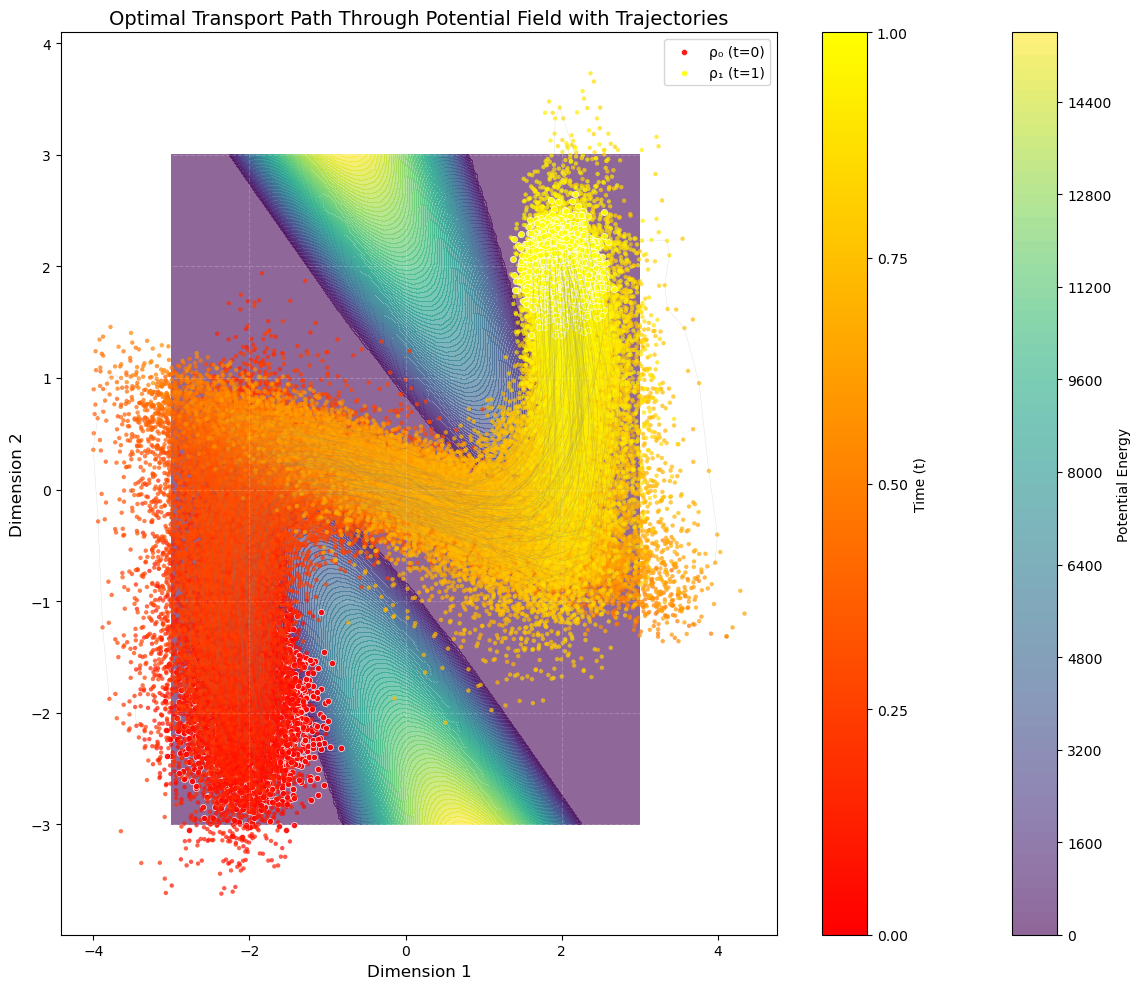

In [9]:
num_samples = 3000
z0 = spline0.prior_dist.sample((num_samples,)).to(device)
interpolation0 = spline0(s)
samples_path0 = path_visualization_with_trajectories(interpolation=interpolation0,arch = arch,
spline = spline0,
x0 = config['visualization']['plot_bounds']['x_min'],
y0 = config['visualization']['plot_bounds']['y_min'],
x1 = config['visualization']['plot_bounds']['x_max'],
y1 = config['visualization']['plot_bounds']['y_max'],
num_samples = 50,
time_steps = 20,solver = 'midpoint',
z = z0,num_contour_points = 100)

In [10]:
if spline0.fisher_pot and not spline0.entropy_pot:
    norm_socre0,samples_path0 = spline0.gen_sample_trajectory(z0,num_samples=len(z0),t_traj=s,time_steps_node=10,solver='midpoint')
    entropy = None
elif spline0.entropy_pot and not spline0.fisher_pot:
    entropy,samples_path0 = spline0.gen_sample_trajectory(z0,num_samples=len(z0),t_traj=s,time_steps_node=10,solver='midpoint')
    norm_score0 = None
elif spline0.entropy_pot and spline0.fisher_pot:
    entropy,norm_socre0,samples_path0 = spline0.gen_sample_trajectory(z0,num_samples=len(z0),t_traj=s,time_steps_node=10,solver='midpoint')
else:
    entropy = None
    norm_socre0 = None

lagrangian0,ke,pe = spline0.lagrangian(samples_path0.to(device),s,log_density= entropy,score=norm_socre0)

print(lagrangian0,ke,pe)

tensor(155.6895, device='cuda:3') tensor(41.5007, device='cuda:3') tensor(114.1888, device='cuda:3')


In [11]:
samples_path0.shape

torch.Size([3000, 30, 2])

In [12]:
# Now lets import samples form another algorithm
# This will have to be improved to also work with gsbm

path = str(root_path)+ '/results_gsbm/scurve/seed0'

import pickle
import jax
import numpy as np
with open(path + '/xs.pickle', 'rb') as f:
    samples = pickle.load(f)

# samples_path = torch.from_numpy(np.asarray(samples))
samples_path =samples['xs'].detach().cpu()

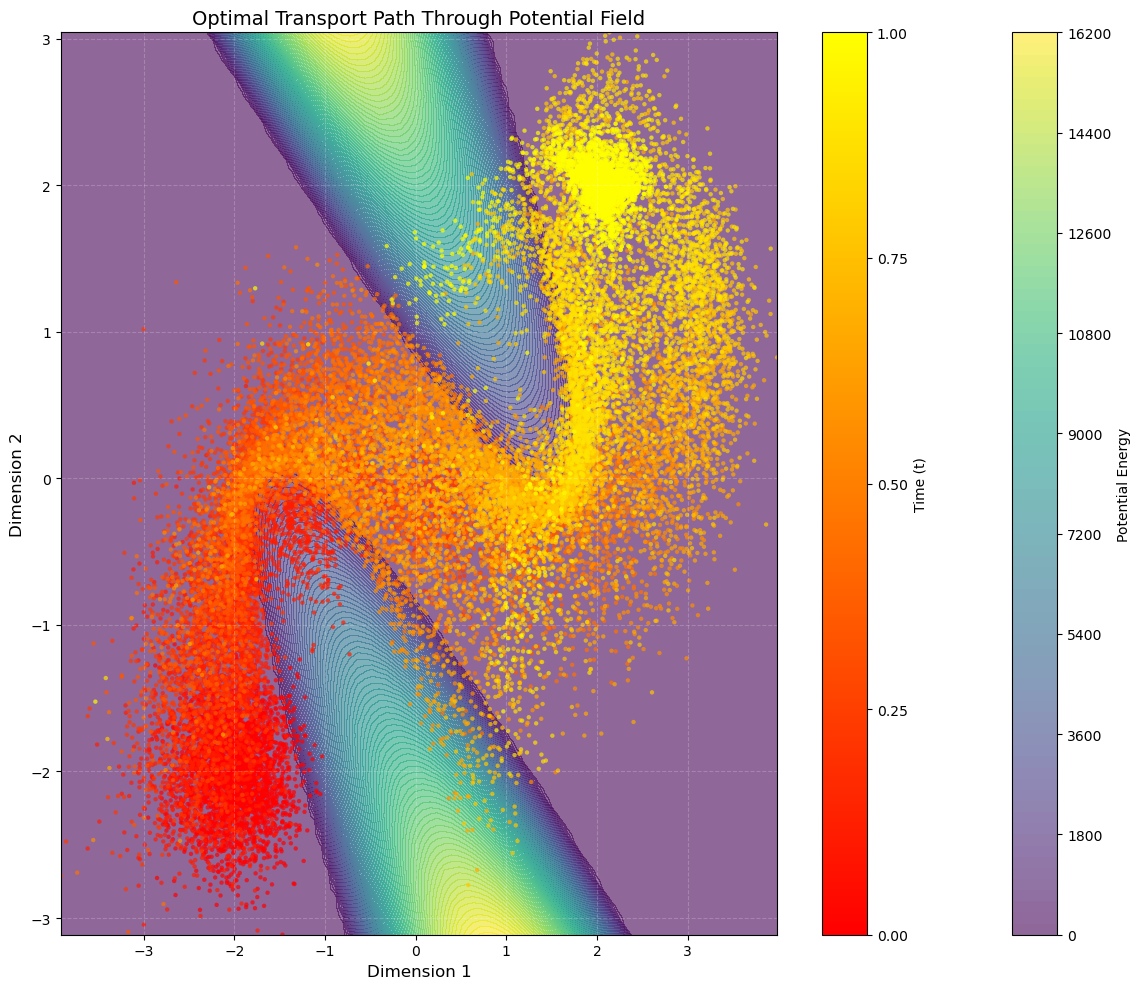

In [13]:
path_visualization_particles(samples_path,spline0)

In [14]:
spline0.lagrangian(samples['xs'],samples['t'])

(tensor(266.7186, device='cuda:0'),
 tensor(32.4801, device='cuda:0'),
 tensor(234.2386, device='cuda:0'))

In [15]:
animation = create_particle_animation(spline0,samples_path0.detach().cpu().permute(1,0,2),x0 = config['visualization']['plot_bounds']['x_min'],
y0 = config['visualization']['plot_bounds']['y_min'],
x1 = config['visualization']['plot_bounds']['x_max'],
y1 = config['visualization']['plot_bounds']['y_max'],interval=250)
display(animation)

/work/Sebas/miniconda3/envs/PDPO/lib/python3.12/site-packages/torch/functional.py:539: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:3637.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [16]:
animation = create_particle_animation(spline0,samples['xs'].detach().cpu().permute(1,0,2),x0 = config['visualization']['plot_bounds']['x_min'],
y0 = config['visualization']['plot_bounds']['y_min'],
x1 = config['visualization']['plot_bounds']['x_max'],
y1 = config['visualization']['plot_bounds']['y_max'],interval=250)
display(animation)